In [1]:
import time
import numpy as np
import pandas as pd
import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep

import pickle as pkl
import sys
sys.path.insert(0,'..')
from models import ParticleNet
import torch
import torch.nn as nn
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.data import Data, Batch

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline

import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

import networkx as nx
import torch
import torch_geometric
import numpy as np
import pickle as pkl

## TEST TRAINING

In [2]:
! ls ./

ParticleNet_1     Roc_curve.pdf     particlenet.ipynb
ParticleNet_6     fastjet.ipynb     results.pdf
ParticleNet_model paper             xai_plots


In [108]:
# load the trained model
device = 'cpu'
PATH = "ParticleNet_6"
# PATH = "ParticleNet_1"

with open(f"{PATH}/model_kwargs.pkl", "rb") as f:
    model_kwargs = pkl.load(f)

state_dict = torch.load(f"{PATH}/best_epoch_weights.pth", map_location=device)

model = ParticleNet(**model_kwargs)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
test_data = torch.load("../data/toptagging/test/processed/data_0.pt")
loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [111]:
# all test data
data = []
for i in range(4):
    data = data + torch.load(f"../data/toptagging/test/processed/data_{i}.pt")
loader = DataLoader(data, batch_size=1, shuffle=True)

In [114]:
from tqdm.notebook import tqdm
sig = nn.Sigmoid()

y_score = None
y_test = None
for i, batch in tqdm(enumerate(loader)):
    preds, _, _, _ = model(batch)
    preds = sig(preds).detach()
    
    if y_score == None:
        y_score = preds[:].reshape(-1)
        y_test = batch.y
    else:
        y_score = torch.cat([y_score, preds[:].reshape(-1)])
        y_test = torch.cat([y_test, batch.y]) 
        
#     if i==10000:
#         break

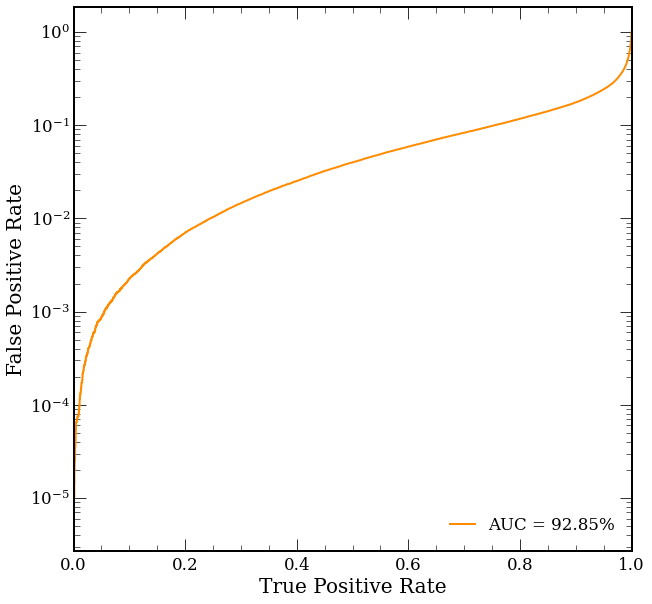

<Figure size 720x720 with 0 Axes>

In [120]:
# Compute ROC curve and ROC area for each class    
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
ax.plot(
    tpr,
    fpr,
    color="darkorange",
    lw=2,
    label=f"AUC = {round(auc(fpr, tpr)*100,2)}%",
)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.yscale('log')
# plt.title("")
plt.legend(loc="lower right")
plt.show()
plt.savefig('Roc_curve.pdf');

# TEST LRP: dR and M_ij

In [4]:
def get_dr_Mij(trained=True):
    dr_top = []
    dr_qcd = []
    Mij_top = []
    Mij_qcd= []
        
    if trained:
        loops = 1    
    else:
        loops = 10
        
    for loop, models in enumerate(range(loops)):

        if trained:
            PATH = "ParticleNet_6/Rscores_best_10k"
        else:
            PATH = f"ParticleNet_6/Rscores_{loop}"

        with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
            batch_x_list = pkl.load(handle)
        with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
            batch_y_list = pkl.load(handle)

        with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
            R_edges_list = pkl.load(handle)    
        with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
            edge_index_list = pkl.load(handle)

        with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
            batch_px_list = pkl.load(handle)
        with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
            batch_py_list = pkl.load(handle)  
        with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
            batch_pz_list = pkl.load(handle)
        with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
            batch_E_list = pkl.load(handle)     
        print(f'loop {loop}')
        for i in range(len(batch_y_list)):
            print(f'{i}/{len(batch_y_list)}')
            jet_label = batch_y_list[i]
            jet_input = batch_x_list[i]

            R_edges = R_edges_list[i]
            edge_index = edge_index_list[i]

#             if trained:        
            R_edges = R_edges['edge_conv_2']
            edge_index = edge_index['edge_conv_2']

            px = batch_px_list[i]
            py = batch_py_list[i]
            pz = batch_pz_list[i]
            e = batch_E_list[i]

            p = torch.sqrt(torch.square(px) + torch.square(py) + torch.square(pz))

            # recall: Features, in order: [eta, phi, pt, mask].
            eta = jet_input[:, 0]
            phi = jet_input[:, 1]
            pt = np.abs(jet_input[:, 2])

            eta_phi = jet_input[:, :2]

            # build graph
            edge_index, edge_weight = edge_index, torch.abs(R_edges).sum(axis=1)
            edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

            def deltaR(eta1, eta2, phi1, phi2):
                return torch.sqrt(torch.square(eta2-eta1) + torch.square(phi2-phi1))

            top_5_edges = torch.topk(edge_Rscores, 5).indices   # pick top 5 edge Rscores, get the indices

            for edge in top_5_edges:
                particle_1 = edge_index[0][edge]
                particle_2 = edge_index[1][edge]

                px1 = px[particle_1]
                py1 = py[particle_1]
                pz1 = pz[particle_1]

                px2 = px[particle_2]
                py2 = py[particle_2]
                pz2 = pz[particle_2]

                eta1 = eta[particle_1]
                eta2 = eta[particle_2]

                phi1 = phi[particle_1]
                phi2 = phi[particle_2]

                e1 = e[particle_1]
                e2 = e[particle_2]

                M12 = torch.sqrt(torch.square(e1+e2) - torch.square(px1+ px2) - torch.square(py1+py2) - torch.square(pz1+pz2))

                if jet_label==1:
                    dr_top.append(deltaR(eta1, eta2, phi1, phi2).item())
                    Mij_top.append(M12)
                else:
                    dr_qcd.append(deltaR(eta1, eta2, phi1, phi2).item())
                    Mij_qcd.append(M12) 

    return dr_top, dr_qcd, Mij_top, Mij_qcd

## Make and save

In [5]:
dr_top_trained, dr_qcd_trained, Mij_top_trained, Mij_qcd_trained = get_dr_Mij(trained=True)

with open('paper/dr_top_trained.pkl', 'wb') as f:
    pkl.dump(dr_top_trained, f)
with open('paper/dr_qcd_trained.pkl', 'wb') as f:
    pkl.dump(dr_qcd_trained, f)
with open('paper/Mij_top_trained.pkl', 'wb') as f:
    pkl.dump(Mij_top_trained, f)
with open('paper/Mij_qcd_trained.pkl', 'wb') as f:
    pkl.dump(Mij_qcd_trained, f)

loop 0
0/9950
1/9950
2/9950
3/9950
4/9950
5/9950
6/9950
7/9950
8/9950
9/9950
10/9950
11/9950
12/9950
13/9950
14/9950
15/9950
16/9950
17/9950
18/9950
19/9950
20/9950
21/9950
22/9950
23/9950
24/9950
25/9950
26/9950
27/9950
28/9950
29/9950
30/9950
31/9950
32/9950
33/9950
34/9950
35/9950
36/9950
37/9950
38/9950
39/9950
40/9950
41/9950
42/9950
43/9950
44/9950
45/9950
46/9950
47/9950
48/9950
49/9950
50/9950
51/9950
52/9950
53/9950
54/9950
55/9950
56/9950
57/9950
58/9950
59/9950
60/9950
61/9950
62/9950
63/9950
64/9950
65/9950
66/9950
67/9950
68/9950
69/9950
70/9950
71/9950
72/9950
73/9950
74/9950
75/9950
76/9950
77/9950
78/9950
79/9950
80/9950
81/9950
82/9950
83/9950
84/9950
85/9950
86/9950
87/9950
88/9950
89/9950
90/9950
91/9950
92/9950
93/9950
94/9950
95/9950
96/9950
97/9950
98/9950
99/9950
100/9950
101/9950
102/9950
103/9950
104/9950
105/9950
106/9950
107/9950
108/9950
109/9950
110/9950
111/9950
112/9950
113/9950
114/9950
115/9950
116/9950
117/9950
118/9950
119/9950
120/9950
121/9950
122/9

981/9950
982/9950
983/9950
984/9950
985/9950
986/9950
987/9950
988/9950
989/9950
990/9950
991/9950
992/9950
993/9950
994/9950
995/9950
996/9950
997/9950
998/9950
999/9950
1000/9950
1001/9950
1002/9950
1003/9950
1004/9950
1005/9950
1006/9950
1007/9950
1008/9950
1009/9950
1010/9950
1011/9950
1012/9950
1013/9950
1014/9950
1015/9950
1016/9950
1017/9950
1018/9950
1019/9950
1020/9950
1021/9950
1022/9950
1023/9950
1024/9950
1025/9950
1026/9950
1027/9950
1028/9950
1029/9950
1030/9950
1031/9950
1032/9950
1033/9950
1034/9950
1035/9950
1036/9950
1037/9950
1038/9950
1039/9950
1040/9950
1041/9950
1042/9950
1043/9950
1044/9950
1045/9950
1046/9950
1047/9950
1048/9950
1049/9950
1050/9950
1051/9950
1052/9950
1053/9950
1054/9950
1055/9950
1056/9950
1057/9950
1058/9950
1059/9950
1060/9950
1061/9950
1062/9950
1063/9950
1064/9950
1065/9950
1066/9950
1067/9950
1068/9950
1069/9950
1070/9950
1071/9950
1072/9950
1073/9950
1074/9950
1075/9950
1076/9950
1077/9950
1078/9950
1079/9950
1080/9950
1081/9950
1082/9950

1872/9950
1873/9950
1874/9950
1875/9950
1876/9950
1877/9950
1878/9950
1879/9950
1880/9950
1881/9950
1882/9950
1883/9950
1884/9950
1885/9950
1886/9950
1887/9950
1888/9950
1889/9950
1890/9950
1891/9950
1892/9950
1893/9950
1894/9950
1895/9950
1896/9950
1897/9950
1898/9950
1899/9950
1900/9950
1901/9950
1902/9950
1903/9950
1904/9950
1905/9950
1906/9950
1907/9950
1908/9950
1909/9950
1910/9950
1911/9950
1912/9950
1913/9950
1914/9950
1915/9950
1916/9950
1917/9950
1918/9950
1919/9950
1920/9950
1921/9950
1922/9950
1923/9950
1924/9950
1925/9950
1926/9950
1927/9950
1928/9950
1929/9950
1930/9950
1931/9950
1932/9950
1933/9950
1934/9950
1935/9950
1936/9950
1937/9950
1938/9950
1939/9950
1940/9950
1941/9950
1942/9950
1943/9950
1944/9950
1945/9950
1946/9950
1947/9950
1948/9950
1949/9950
1950/9950
1951/9950
1952/9950
1953/9950
1954/9950
1955/9950
1956/9950
1957/9950
1958/9950
1959/9950
1960/9950
1961/9950
1962/9950
1963/9950
1964/9950
1965/9950
1966/9950
1967/9950
1968/9950
1969/9950
1970/9950
1971/9950


2750/9950
2751/9950
2752/9950
2753/9950
2754/9950
2755/9950
2756/9950
2757/9950
2758/9950
2759/9950
2760/9950
2761/9950
2762/9950
2763/9950
2764/9950
2765/9950
2766/9950
2767/9950
2768/9950
2769/9950
2770/9950
2771/9950
2772/9950
2773/9950
2774/9950
2775/9950
2776/9950
2777/9950
2778/9950
2779/9950
2780/9950
2781/9950
2782/9950
2783/9950
2784/9950
2785/9950
2786/9950
2787/9950
2788/9950
2789/9950
2790/9950
2791/9950
2792/9950
2793/9950
2794/9950
2795/9950
2796/9950
2797/9950
2798/9950
2799/9950
2800/9950
2801/9950
2802/9950
2803/9950
2804/9950
2805/9950
2806/9950
2807/9950
2808/9950
2809/9950
2810/9950
2811/9950
2812/9950
2813/9950
2814/9950
2815/9950
2816/9950
2817/9950
2818/9950
2819/9950
2820/9950
2821/9950
2822/9950
2823/9950
2824/9950
2825/9950
2826/9950
2827/9950
2828/9950
2829/9950
2830/9950
2831/9950
2832/9950
2833/9950
2834/9950
2835/9950
2836/9950
2837/9950
2838/9950
2839/9950
2840/9950
2841/9950
2842/9950
2843/9950
2844/9950
2845/9950
2846/9950
2847/9950
2848/9950
2849/9950


3626/9950
3627/9950
3628/9950
3629/9950
3630/9950
3631/9950
3632/9950
3633/9950
3634/9950
3635/9950
3636/9950
3637/9950
3638/9950
3639/9950
3640/9950
3641/9950
3642/9950
3643/9950
3644/9950
3645/9950
3646/9950
3647/9950
3648/9950
3649/9950
3650/9950
3651/9950
3652/9950
3653/9950
3654/9950
3655/9950
3656/9950
3657/9950
3658/9950
3659/9950
3660/9950
3661/9950
3662/9950
3663/9950
3664/9950
3665/9950
3666/9950
3667/9950
3668/9950
3669/9950
3670/9950
3671/9950
3672/9950
3673/9950
3674/9950
3675/9950
3676/9950
3677/9950
3678/9950
3679/9950
3680/9950
3681/9950
3682/9950
3683/9950
3684/9950
3685/9950
3686/9950
3687/9950
3688/9950
3689/9950
3690/9950
3691/9950
3692/9950
3693/9950
3694/9950
3695/9950
3696/9950
3697/9950
3698/9950
3699/9950
3700/9950
3701/9950
3702/9950
3703/9950
3704/9950
3705/9950
3706/9950
3707/9950
3708/9950
3709/9950
3710/9950
3711/9950
3712/9950
3713/9950
3714/9950
3715/9950
3716/9950
3717/9950
3718/9950
3719/9950
3720/9950
3721/9950
3722/9950
3723/9950
3724/9950
3725/9950


4489/9950
4490/9950
4491/9950
4492/9950
4493/9950
4494/9950
4495/9950
4496/9950
4497/9950
4498/9950
4499/9950
4500/9950
4501/9950
4502/9950
4503/9950
4504/9950
4505/9950
4506/9950
4507/9950
4508/9950
4509/9950
4510/9950
4511/9950
4512/9950
4513/9950
4514/9950
4515/9950
4516/9950
4517/9950
4518/9950
4519/9950
4520/9950
4521/9950
4522/9950
4523/9950
4524/9950
4525/9950
4526/9950
4527/9950
4528/9950
4529/9950
4530/9950
4531/9950
4532/9950
4533/9950
4534/9950
4535/9950
4536/9950
4537/9950
4538/9950
4539/9950
4540/9950
4541/9950
4542/9950
4543/9950
4544/9950
4545/9950
4546/9950
4547/9950
4548/9950
4549/9950
4550/9950
4551/9950
4552/9950
4553/9950
4554/9950
4555/9950
4556/9950
4557/9950
4558/9950
4559/9950
4560/9950
4561/9950
4562/9950
4563/9950
4564/9950
4565/9950
4566/9950
4567/9950
4568/9950
4569/9950
4570/9950
4571/9950
4572/9950
4573/9950
4574/9950
4575/9950
4576/9950
4577/9950
4578/9950
4579/9950
4580/9950
4581/9950
4582/9950
4583/9950
4584/9950
4585/9950
4586/9950
4587/9950
4588/9950


5309/9950
5310/9950
5311/9950
5312/9950
5313/9950
5314/9950
5315/9950
5316/9950
5317/9950
5318/9950
5319/9950
5320/9950
5321/9950
5322/9950
5323/9950
5324/9950
5325/9950
5326/9950
5327/9950
5328/9950
5329/9950
5330/9950
5331/9950
5332/9950
5333/9950
5334/9950
5335/9950
5336/9950
5337/9950
5338/9950
5339/9950
5340/9950
5341/9950
5342/9950
5343/9950
5344/9950
5345/9950
5346/9950
5347/9950
5348/9950
5349/9950
5350/9950
5351/9950
5352/9950
5353/9950
5354/9950
5355/9950
5356/9950
5357/9950
5358/9950
5359/9950
5360/9950
5361/9950
5362/9950
5363/9950
5364/9950
5365/9950
5366/9950
5367/9950
5368/9950
5369/9950
5370/9950
5371/9950
5372/9950
5373/9950
5374/9950
5375/9950
5376/9950
5377/9950
5378/9950
5379/9950
5380/9950
5381/9950
5382/9950
5383/9950
5384/9950
5385/9950
5386/9950
5387/9950
5388/9950
5389/9950
5390/9950
5391/9950
5392/9950
5393/9950
5394/9950
5395/9950
5396/9950
5397/9950
5398/9950
5399/9950
5400/9950
5401/9950
5402/9950
5403/9950
5404/9950
5405/9950
5406/9950
5407/9950
5408/9950


6134/9950
6135/9950
6136/9950
6137/9950
6138/9950
6139/9950
6140/9950
6141/9950
6142/9950
6143/9950
6144/9950
6145/9950
6146/9950
6147/9950
6148/9950
6149/9950
6150/9950
6151/9950
6152/9950
6153/9950
6154/9950
6155/9950
6156/9950
6157/9950
6158/9950
6159/9950
6160/9950
6161/9950
6162/9950
6163/9950
6164/9950
6165/9950
6166/9950
6167/9950
6168/9950
6169/9950
6170/9950
6171/9950
6172/9950
6173/9950
6174/9950
6175/9950
6176/9950
6177/9950
6178/9950
6179/9950
6180/9950
6181/9950
6182/9950
6183/9950
6184/9950
6185/9950
6186/9950
6187/9950
6188/9950
6189/9950
6190/9950
6191/9950
6192/9950
6193/9950
6194/9950
6195/9950
6196/9950
6197/9950
6198/9950
6199/9950
6200/9950
6201/9950
6202/9950
6203/9950
6204/9950
6205/9950
6206/9950
6207/9950
6208/9950
6209/9950
6210/9950
6211/9950
6212/9950
6213/9950
6214/9950
6215/9950
6216/9950
6217/9950
6218/9950
6219/9950
6220/9950
6221/9950
6222/9950
6223/9950
6224/9950
6225/9950
6226/9950
6227/9950
6228/9950
6229/9950
6230/9950
6231/9950
6232/9950
6233/9950


6971/9950
6972/9950
6973/9950
6974/9950
6975/9950
6976/9950
6977/9950
6978/9950
6979/9950
6980/9950
6981/9950
6982/9950
6983/9950
6984/9950
6985/9950
6986/9950
6987/9950
6988/9950
6989/9950
6990/9950
6991/9950
6992/9950
6993/9950
6994/9950
6995/9950
6996/9950
6997/9950
6998/9950
6999/9950
7000/9950
7001/9950
7002/9950
7003/9950
7004/9950
7005/9950
7006/9950
7007/9950
7008/9950
7009/9950
7010/9950
7011/9950
7012/9950
7013/9950
7014/9950
7015/9950
7016/9950
7017/9950
7018/9950
7019/9950
7020/9950
7021/9950
7022/9950
7023/9950
7024/9950
7025/9950
7026/9950
7027/9950
7028/9950
7029/9950
7030/9950
7031/9950
7032/9950
7033/9950
7034/9950
7035/9950
7036/9950
7037/9950
7038/9950
7039/9950
7040/9950
7041/9950
7042/9950
7043/9950
7044/9950
7045/9950
7046/9950
7047/9950
7048/9950
7049/9950
7050/9950
7051/9950
7052/9950
7053/9950
7054/9950
7055/9950
7056/9950
7057/9950
7058/9950
7059/9950
7060/9950
7061/9950
7062/9950
7063/9950
7064/9950
7065/9950
7066/9950
7067/9950
7068/9950
7069/9950
7070/9950


7813/9950
7814/9950
7815/9950
7816/9950
7817/9950
7818/9950
7819/9950
7820/9950
7821/9950
7822/9950
7823/9950
7824/9950
7825/9950
7826/9950
7827/9950
7828/9950
7829/9950
7830/9950
7831/9950
7832/9950
7833/9950
7834/9950
7835/9950
7836/9950
7837/9950
7838/9950
7839/9950
7840/9950
7841/9950
7842/9950
7843/9950
7844/9950
7845/9950
7846/9950
7847/9950
7848/9950
7849/9950
7850/9950
7851/9950
7852/9950
7853/9950
7854/9950
7855/9950
7856/9950
7857/9950
7858/9950
7859/9950
7860/9950
7861/9950
7862/9950
7863/9950
7864/9950
7865/9950
7866/9950
7867/9950
7868/9950
7869/9950
7870/9950
7871/9950
7872/9950
7873/9950
7874/9950
7875/9950
7876/9950
7877/9950
7878/9950
7879/9950
7880/9950
7881/9950
7882/9950
7883/9950
7884/9950
7885/9950
7886/9950
7887/9950
7888/9950
7889/9950
7890/9950
7891/9950
7892/9950
7893/9950
7894/9950
7895/9950
7896/9950
7897/9950
7898/9950
7899/9950
7900/9950
7901/9950
7902/9950
7903/9950
7904/9950
7905/9950
7906/9950
7907/9950
7908/9950
7909/9950
7910/9950
7911/9950
7912/9950


8645/9950
8646/9950
8647/9950
8648/9950
8649/9950
8650/9950
8651/9950
8652/9950
8653/9950
8654/9950
8655/9950
8656/9950
8657/9950
8658/9950
8659/9950
8660/9950
8661/9950
8662/9950
8663/9950
8664/9950
8665/9950
8666/9950
8667/9950
8668/9950
8669/9950
8670/9950
8671/9950
8672/9950
8673/9950
8674/9950
8675/9950
8676/9950
8677/9950
8678/9950
8679/9950
8680/9950
8681/9950
8682/9950
8683/9950
8684/9950
8685/9950
8686/9950
8687/9950
8688/9950
8689/9950
8690/9950
8691/9950
8692/9950
8693/9950
8694/9950
8695/9950
8696/9950
8697/9950
8698/9950
8699/9950
8700/9950
8701/9950
8702/9950
8703/9950
8704/9950
8705/9950
8706/9950
8707/9950
8708/9950
8709/9950
8710/9950
8711/9950
8712/9950
8713/9950
8714/9950
8715/9950
8716/9950
8717/9950
8718/9950
8719/9950
8720/9950
8721/9950
8722/9950
8723/9950
8724/9950
8725/9950
8726/9950
8727/9950
8728/9950
8729/9950
8730/9950
8731/9950
8732/9950
8733/9950
8734/9950
8735/9950
8736/9950
8737/9950
8738/9950
8739/9950
8740/9950
8741/9950
8742/9950
8743/9950
8744/9950


9465/9950
9466/9950
9467/9950
9468/9950
9469/9950
9470/9950
9471/9950
9472/9950
9473/9950
9474/9950
9475/9950
9476/9950
9477/9950
9478/9950
9479/9950
9480/9950
9481/9950
9482/9950
9483/9950
9484/9950
9485/9950
9486/9950
9487/9950
9488/9950
9489/9950
9490/9950
9491/9950
9492/9950
9493/9950
9494/9950
9495/9950
9496/9950
9497/9950
9498/9950
9499/9950
9500/9950
9501/9950
9502/9950
9503/9950
9504/9950
9505/9950
9506/9950
9507/9950
9508/9950
9509/9950
9510/9950
9511/9950
9512/9950
9513/9950
9514/9950
9515/9950
9516/9950
9517/9950
9518/9950
9519/9950
9520/9950
9521/9950
9522/9950
9523/9950
9524/9950
9525/9950
9526/9950
9527/9950
9528/9950
9529/9950
9530/9950
9531/9950
9532/9950
9533/9950
9534/9950
9535/9950
9536/9950
9537/9950
9538/9950
9539/9950
9540/9950
9541/9950
9542/9950
9543/9950
9544/9950
9545/9950
9546/9950
9547/9950
9548/9950
9549/9950
9550/9950
9551/9950
9552/9950
9553/9950
9554/9950
9555/9950
9556/9950
9557/9950
9558/9950
9559/9950
9560/9950
9561/9950
9562/9950
9563/9950
9564/9950


In [129]:
dr_top_untrained, dr_qcd_untrained, Mij_top_untrained, Mij_qcd_untrained = get_dr_Mij(trained=False)

with open('paper/dr_top_untrained.pkl', 'wb') as f:
    pkl.dump(dr_top_untrained, f)
with open('paper/dr_qcd_untrained.pkl', 'wb') as f:
    pkl.dump(dr_qcd_untrained, f)
with open('paper/Mij_top_untrained.pkl', 'wb') as f:
    pkl.dump(Mij_top_untrained, f)
with open('paper/Mij_qcd_untrained.pkl', 'wb') as f:
    pkl.dump(Mij_qcd_untrained, f)    

## Load and plot

In [179]:
# load the trained vars
with open('paper/dr_top_trained.pkl', 'rb') as f:
    dr_top_trained = pkl.load(f)
with open('paper/dr_qcd_trained.pkl', 'rb') as f:
    dr_qcd_trained = pkl.load(f)
with open('paper/Mij_top_trained.pkl', 'rb') as f:
    Mij_top_trained = pkl.load(f)
with open('paper/Mij_qcd_trained.pkl', 'rb') as f:
    Mij_qcd_trained = pkl.load(f)

In [6]:
# load the untrained vars
with open('paper/dr_top_untrained.pkl', 'rb') as f:
    dr_top_untrained = pkl.load(f)
with open('paper/dr_qcd_untrained.pkl', 'rb') as f:
    dr_qcd_untrained = pkl.load(f)
with open('paper/Mij_top_untrained.pkl', 'rb') as f:
    Mij_top_untrained = pkl.load(f)
with open('paper/Mij_qcd_untrained.pkl', 'rb') as f:
    Mij_qcd_untrained = pkl.load(f) 

<ipython-input-9-2a64a3ed5ab1>:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[0].set_ylim(0,20)
<ipython-input-9-2a64a3ed5ab1>:24: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[1].set_ylim(0,20)


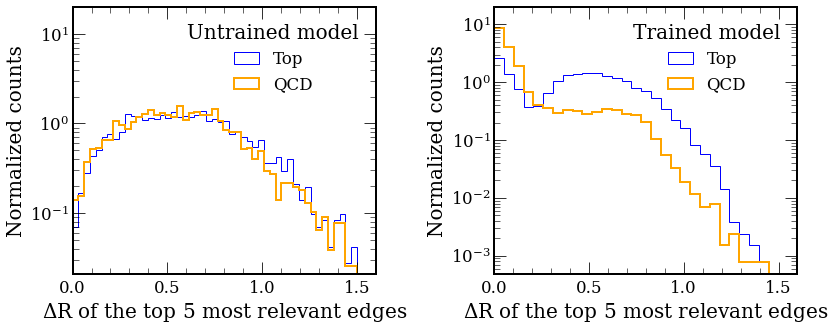

In [9]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
# font.set_family('serif')
font.set_name('Times New Roman')
plt.rcParams.update({'font.family':'serif'}) 
    
# make the plot
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
axes[0].hist(dr_top_untrained, bins=np.linspace(0, 1.5, 50), label='Top', color="Blue", histtype='step', linewidth=1, density=True)
axes[0].hist(dr_qcd_untrained, bins=np.linspace(0, 1.5, 50), label='QCD', color="Orange", histtype='step', linewidth=2, density=True)
axes[0].legend(title='Untrained model')
axes[0].set_yscale('log') 
axes[0].set_ylim(0,20)
axes[0].set_xlim(0,1.6)
axes[0].set_xticks([0,0.5,1,1.5])
axes[0].set_xlabel('$\Delta$R of the top 5 most relevant edges')
axes[0].set_ylabel('Normalized counts')

axes[1].hist(dr_top_trained, bins=np.linspace(0, 1.5, 30), label='Top', color="Blue",histtype='step', linewidth=1, density=True)
axes[1].hist(dr_qcd_trained, bins=np.linspace(0, 1.5, 30), label='QCD', color="Orange",   histtype='step', linewidth=2, density=True)
axes[1].legend(title='Trained model')
axes[1].set_yscale('log') 
axes[1].set_ylim(0,20)
axes[1].set_xlim(0,1.6)
axes[1].set_xticks([0,0.5,1,1.5])
axes[1].set_xlabel('$\Delta$R of the top 5 most relevant edges')
axes[1].set_ylabel('Normalized counts')

fig.tight_layout()

plt.savefig('paper/deltaR.pdf')
plt.show()

<ipython-input-10-7e74385734da>:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[0].set_ylim(0,20)
<ipython-input-10-7e74385734da>:22: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[1].set_ylim(0,20)


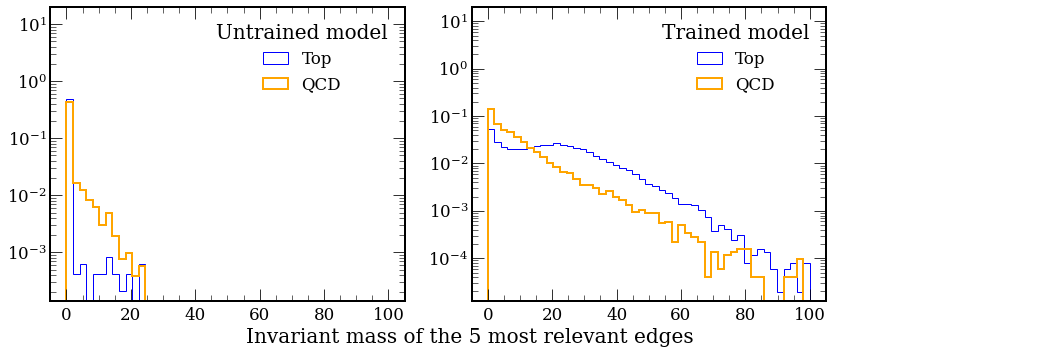

In [10]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
# font.set_family('serif')
font.set_name('Times New Roman')
# plt.rcParams.update({'font.family':'sans-serif'}) 
plt.rcParams.update({'font.family':'serif'}) 

# make the plot
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
axes[0].hist(Mij_top_untrained, bins=np.linspace(0, 100), label='Top', color="Blue", histtype='step', linewidth=1, density=True)
axes[0].hist(Mij_qcd_untrained, bins=np.linspace(0, 100), label='QCD', color="Orange", histtype='step', linewidth=2, density=True)
axes[0].legend(title='Untrained model')
axes[0].set_yscale('log') 
axes[0].set_ylim(0,20)
# axes[0].set_xlabel('Invariant mass of the 5 most relevant edges')

axes[1].hist(Mij_top_trained, bins=np.linspace(0, 100), label='Top', color="Blue",histtype='step', linewidth=1, density=True)
axes[1].hist(Mij_qcd_trained, bins=np.linspace(0, 100), label='QCD', color="Orange",   histtype='step', linewidth=2, density=True)
axes[1].legend(title='Trained model')
axes[1].set_yscale('log') 
axes[1].set_ylim(0,20)

# axes[1].set_xlabel('Invariant mass of the 5 most relevant edges')
fig.tight_layout()

plt.xlabel('Invariant mass of the 5 most relevant edges                                                        ')

plt.savefig('paper/Mij.pdf')
plt.show()

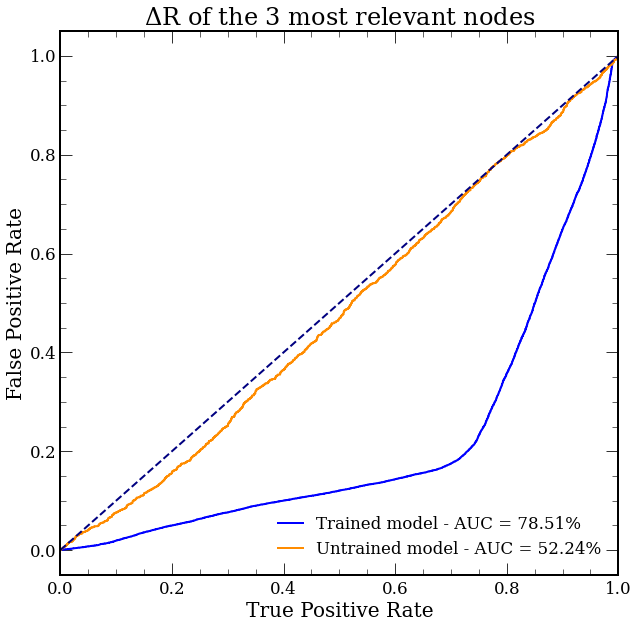

<Figure size 720x720 with 0 Axes>

In [11]:
# Compute ROC curve and ROC area for each class    

score = dr_top_trained + dr_qcd_trained
label = [1] * len(dr_top_trained) + [0] * len(dr_qcd_trained)
fpr_trained, tpr_trained, _ = roc_curve(label, score)
roc_auc = auc(fpr_trained, tpr_trained)

score = dr_top_untrained + dr_qcd_untrained
label = [1] * len(dr_top_untrained) + [0] * len(dr_qcd_untrained)
fpr_untrained, tpr_untrained, _ = roc_curve(label, score)
roc_auc_untrained = auc(fpr_untrained, tpr_untrained)

fig, ax = plt.subplots()
ax.plot(
    tpr_trained,
    fpr_trained,
    color="blue",
    lw=2,
    label=f"Trained model - AUC = {round(auc(fpr_trained, tpr_trained)*100,2)}%",
)
ax.plot(
    tpr_untrained,
    fpr_untrained,
    color="darkorange",
    lw=2,
    label=f"Untrained model - AUC = {round(auc(fpr_untrained, tpr_untrained)*100,2)}%",
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
# plt.yscale('log')
plt.title("$\Delta$R of the 3 most relevant nodes")
plt.legend(loc="lower right")
plt.show()
plt.savefig('Roc_curve.pdf');